In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
compare_loss={}
compare_accuracy={}
import os

C:\Users\muthumn\AppData\Local\conda\conda\envs\newenvt\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data_dir = 'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input'
data_pretrain = 'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/keras-pretrained-models'
data_test = 'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/test'
data_save_model = 'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/saved_models'


In [4]:
train_dir = "C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/train"
valid_dir = "C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/valid"
keras_dir='C:/Users/muthumn/.keras/models'


In [5]:
# data_dir = 'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/'
# train_dir = os.path.join(data_dir, 'train')

In [6]:
train_dir

'C:/Users/muthumn/machine-learning-master/seedlings-pretrained-keras-models/input/train'

In [7]:
# check if all pre trained models are present
start = dt.datetime.now()

In [8]:

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [9]:
# function to convert image to array
def read_img(address, size):
    """Read and resize image.
    Returns Image as numpy array, by normalizing the values
    """
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
#    img = image.load_img(address, target_size=size)
    img = image.img_to_array(img)
    return img

# function to convert labels to one hot encoding vector
def OneHotEncoded(y_train):
    y_t=np.zeros((len(y_train),Num_Class), dtype=int)
    for i,x in enumerate(y_train):
        y_t[i][int(x)-1]=1
    return y_t

In [10]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
           'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
           'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
print(num_species)

12


In [11]:
# Read all train data
train = []
for category_id, category in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category, file])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category', 'encoded_value'])
print('')
print('train.shape = ', train.shape)
train.head(2)


train.shape =  (4750, 4)


,file,category_id,category,encoded_value
0,train/Black-grass/0050f38b3.png,0,Black-grass,0050f38b3.png
1,train/Black-grass/0183fdf68.png,0,Black-grass,0183fdf68.png


In [12]:
# print number of images of each species in the training data

for category in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, category))),category))


263 images of Black-grass
390 images of Charlock
287 images of Cleavers
611 images of Common Chickweed
221 images of Common wheat
475 images of Fat Hen
654 images of Loose Silky-bent
221 images of Maize
516 images of Scentless Mayweed
231 images of Shepherds Purse
496 images of Small-flowered Cranesbill
385 images of Sugar beet


In [13]:
test = []
for file in os.listdir(data_test):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
print('')
print("test.shape =", test.shape )
test.head(2)


test.shape = (794, 2)


,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png


In [14]:
train.index.values

array([   0,    1,    2, ..., 4747, 4748, 4749], dtype=int64)

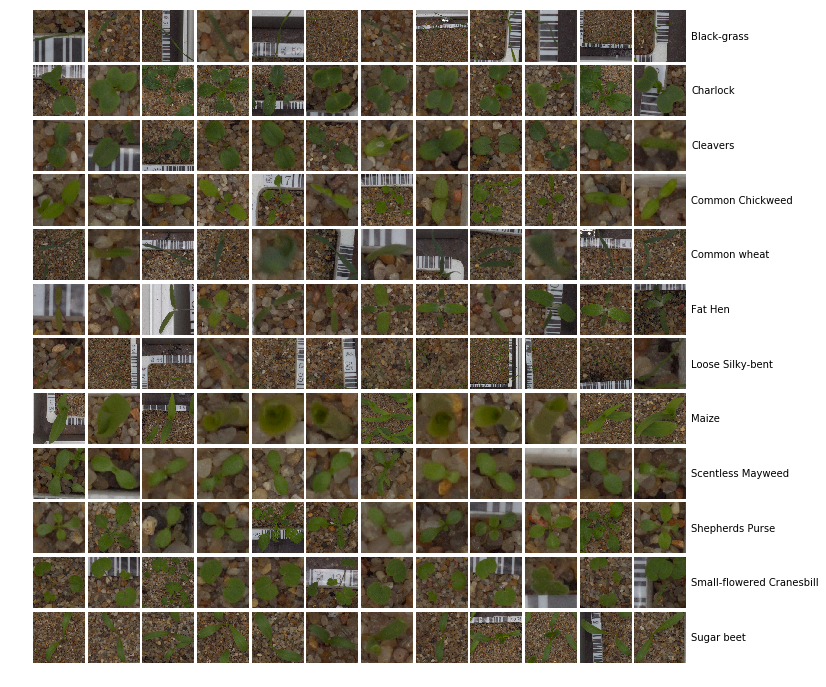

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid

## show 12 images of all species of train data

fig = plt.figure(1, figsize=(num_species, num_species))
grid = ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), axes_pad=0.05)
i = 0
for category_id, category in enumerate(species):
    for filepath in train[train['category'] == category]['file'].values[:num_species]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % num_species == num_species - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

This is our First Method, Here we will Extract VGG16 bottleneck features, by forward passing the processed image data, and then using this forward pass data as input to logistic regression for classification.

We don't need any form of preprocessing on our image data, that has been handled by preprocess_input function of VGG.


In [16]:
INPUT_SIZE = 244
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
y_train= np.zeros((len(train),), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
    y_train[i]=int(train['category_id'][i])
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))
print('Train Images shape: {} size: {:,}'.format(y_train.shape, y_train.size))


4750it [00:45, 104.93it/s]


Train Images shape: (4750, 244, 244, 3) size: 848,388,000
Train Images shape: (4750,) size: 4,750


In [17]:
Num_Class=num_species   # number of classes in dataset
# convert labels to one hot encoding
y_train=OneHotEncoded(y_train)
# split data in to training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print((X_train.shape, X_val.shape, Y_train.shape, Y_val.shape))

((3182, 244, 244, 3), (1568, 244, 244, 3), (3182, 12), (1568, 12))


In [15]:
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))
print('')
print('save bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_vgg_bf.npy'), train_vgg_bf)
np.save(os.path.join(data_save_model,'valid_vgg_bf.npy'), valid_vgg_bf)



1568/1568 [==============================] - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 48s - ETA: 36 - ETA: 24 - ETA: 12 - 604s 385ms/step
VGG train bottleneck features shape: (3182, 512) size: 1,629,184
VGG valid bottleneck features shape: (1568, 512) size: 802,816

save bottleneck features and labels for later 


In [18]:
# load bottleneck features and labels
train_vgg_bf = np.load(os.path.join(data_save_model,'train_vgg_bf.npy'))
valid_vgg_bf = np.load(os.path.join(data_save_model,'valid_vgg_bf.npy'))

print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size)) 
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))



VGG train bottleneck features shape: (3182, 512) size: 1,629,184
VGG valid bottleneck features shape: (1568, 512) size: 802,816


In [22]:
Y_train_val=[]
Y_vali_val=[]
Y_train_val = (Y_train * range(Num_Class)).sum(axis=1)
Y_vali_val = (Y_val * range(Num_Class)).sum(axis=1)


In [23]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
# logreg.fit(train_vgg_bf, (y_train * range(Num_Class)).sum(axis=1))
logreg.fit(train_vgg_bf, Y_train_val)
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)
compare_loss['Vgg16']=log_loss(Y_val, valid_probs)
# compare_accuracy['Vgg16']=accuracy_score((y_val * range(Num_Class)).sum(axis=1), valid_preds)
compare_accuracy['Vgg16']=accuracy_score(Y_vali_val, valid_preds)
print('Validation VGG LogLoss {}'.format(compare_loss['Vgg16']))
print('Validation VGG Accuracy {}'.format(compare_accuracy['Vgg16']))

Validation VGG LogLoss 0.807683561795666
Validation VGG Accuracy 0.7429846938775511


we just use last layer as logistic regression, basically one layered neural network(cross entropy). The accuracy we obtained is around 78.73%

In [25]:
acc_train_vgg_logreg = logreg.score(train_vgg_bf, Y_train_val)
acc_test_vgg_logreg = logreg.score(valid_vgg_bf, Y_vali_val)

print('Logistic Regression + Vgg16')
print('Accuracy train = %.4f and valid = %.4f'%(acc_train_vgg_logreg, acc_test_vgg_logreg))



Logistic Regression + Vgg16
Accuracy train = 0.7772 and valid = 0.7430


### F1- Score  ( VGG16 )

For getting more information on f1_score [click here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [26]:
print('Validation Xception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='macro')*100))
print('Validation Xception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='micro')*100))
print('Validation Xception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='weighted')*100))


Validation Xception F1-Score is 71.5
Validation Xception F1-Score is 74.3
Validation Xception F1-Score is 73.8


Here we will test with Xception bottleneck features, and use these features to train logistic regression.

In [27]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
y_train= np.zeros((len(train),), dtype='float32')

for i, img_id in tqdm(enumerate(train['file'])):
    img = read_img(img_id, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0)) # preprocessing data for Xception model
    x_train[i] = x
    y_train[i]=int(train['category_id'][i])
    
y_train=OneHotEncoded(y_train)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

print((X_train.shape, X_val.shape, Y_train.shape, Y_val.shape))

4750it [01:00, 78.55it/s]


((3182, 299, 299, 3), (1568, 299, 299, 3), (3182, 12), (1568, 12))

In [37]:
# forward passing the training and validation set
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))
print('')
print('save Xception train bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_x_bf.npy'), train_x_bf)
np.save(os.path.join(data_save_model,'valid_x_bf.npy'), valid_x_bf)

1568/1568 [==============================] - ETA: 37:0 - ETA: 37:1 - ETA: 36:1 - ETA: 35:2 - ETA: 34:3 - ETA: 33:3 - ETA: 32:4 - ETA: 32:1 - ETA: 31:3 - ETA: 30:4 - ETA: 30:0 - ETA: 29:1 - ETA: 28:2 - ETA: 27:2 - ETA: 26:4 - ETA: 25:4 - ETA: 24:5 - ETA: 24:1 - ETA: 23:2 - ETA: 22:3 - ETA: 21:4 - ETA: 20:5 - ETA: 20:1 - ETA: 19:3 - ETA: 18:4 - ETA: 18:0 - ETA: 17:1 - ETA: 16:2 - ETA: 15:3 - ETA: 14:4 - ETA: 14:0 - ETA: 13:1 - ETA: 12:2 - ETA: 11:4 - ETA: 10:5 - ETA: 10:0 - ETA: 9:1 - ETA: 8: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 46s - 2264s 1s/step
Xception train bottleneck features shape: (3182, 2048) size: 6,516,736
Xception valid bottleneck features shape: (1568, 2048) size: 3,211,264


In [28]:
# load bottleneck features and labels
train_x_bf = np.load(os.path.join(data_save_model,'train_x_bf.npy'))
valid_x_bf = np.load(os.path.join(data_save_model,'valid_x_bf.npy'))

print('VGG train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size)) 
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))


VGG train bottleneck features shape: (3182, 2048) size: 6,516,736
VGG valid bottleneck features shape: (1568, 2048) size: 3,211,264


In [29]:
Y_train_val=[]
Y_vali_val=[]
Y_train_val = (Y_train * range(Num_Class)).sum(axis=1)
Y_vali_val = (Y_val * range(Num_Class)).sum(axis=1)

In [30]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
logreg.fit(train_x_bf, Y_train_val)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
compare_loss['Xception']=log_loss(Y_val, valid_probs)
compare_accuracy['Xception']=accuracy_score(Y_vali_val, valid_preds)
print('Validation Xception LogLoss {}'.format(compare_loss['Xception']))
print('Validation Xception Accuracy {}'.format(compare_accuracy['Xception']))

Validation Xception LogLoss 0.4069318232911793
Validation Xception Accuracy 0.8673469387755102


In [31]:
acc_train_Xception_logreg = logreg.score(train_x_bf, Y_train_val)
acc_test_Xception_logreg = logreg.score(valid_x_bf, Y_vali_val)

print('Logistic Regression + Xception')
print('Accuracy train = %.4f and valid = %.4f'%(acc_train_Xception_logreg, acc_test_Xception_logreg))


Logistic Regression + Xception
Accuracy train = 0.9981 and valid = 0.8673


### F1- Score ( Xception )

For getting more information on f1_score [click here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [32]:
print('Validation Xception logreg F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='macro')*100))
print('Validation Xception logreg F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='micro')*100))
print('Validation Xception logreg F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='weighted')*100))


Validation Xception logreg F1-Score is 85.8
Validation Xception logreg F1-Score is 86.7
Validation Xception logreg F1-Score is 86.7


### RandomForest on Xception bottleneck features

In [33]:
## random forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=num_species)
random_forest.fit(train_x_bf, Y_train_val)

acc_train_random_forest = random_forest.score(train_x_bf, Y_train_val)
acc_valid_random_forest = random_forest.score(valid_x_bf, Y_vali_val)

print('Random Forest')
print('Accuracy train/valid = %.4f/%.4f'%(acc_train_random_forest, acc_valid_random_forest))

Random Forest
Accuracy train/valid = 0.9981/0.6180


In [35]:
print('Validation Xception RandomForest F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='macro')*100))
print('Validation Xception RandomForest F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='micro')*100))
print('Validation Xception RandomForest F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='weighted')*100))


Validation Xception RandomForest F1-Score is 85.8
Validation Xception RandomForest F1-Score is 86.7
Validation Xception RandomForest F1-Score is 86.7


In this step we have extracted Inception Bottleneck Features, and stacked them with Xception Features. This way we improved our input features.
Though Our Accuracy is looking almost same, but our loss reduced.

In [39]:

inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(X_val, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

print('')
print('save InceptionV3 train bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_i_bf.npy'), train_i_bf)
np.save(os.path.join(data_save_model,'valid_i_bf.npy'), valid_i_bf)

1568/1568 [==============================] - ETA: 16:1 - ETA: 15:4 - ETA: 15:1 - ETA: 15:0 - ETA: 14:4 - ETA: 14:3 - ETA: 14:1 - ETA: 13:5 - ETA: 13:3 - ETA: 13:2 - ETA: 12:5 - ETA: 12:3 - ETA: 12:1 - ETA: 11:5 - ETA: 11:3 - ETA: 11:1 - ETA: 10:5 - ETA: 10:2 - ETA: 10:1 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 43s - ETA: 21 - 1061s 677ms/step
InceptionV3 train bottleneck features shape: (3182, 2048) size: 6,516,736
InceptionV3 valid bottleneck features shape: (1568, 2048) size: 3,211,264


In [36]:
# load bottleneck features and labels
train_i_bf = np.load(os.path.join(data_save_model,'train_i_bf.npy'))
valid_i_bf = np.load(os.path.join(data_save_model,'valid_i_bf.npy'))

print('VGG train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size)) 
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))


VGG train bottleneck features shape: (3182, 2048) size: 6,516,736
VGG valid bottleneck features shape: (1568, 2048) size: 3,211,264


In [37]:
Y_train_val=[]
Y_vali_val=[]
Y_train_val = (Y_train * range(Num_Class)).sum(axis=1)
Y_vali_val = (Y_val * range(Num_Class)).sum(axis=1)

In [38]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1987)
logreg.fit(train_i_bf, Y_train_val)
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)
compare_loss['Xception_Inception']=log_loss(Y_val, valid_probs)
compare_accuracy['Xception_Inception']=accuracy_score(Y_vali_val, valid_preds)
print('Validation Xception + Inception LogLoss {}'.format(compare_loss['Xception_Inception']))
print('Validation Xception + Inception Accuracy {}'.format(compare_accuracy['Xception_Inception']))

Validation Xception + Inception LogLoss 0.4641471250725175
Validation Xception + Inception Accuracy 0.8565051020408163


In [39]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])

print('')
print('save Xception + InceptionV3 train bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_x_i_bf.npy'), X)
np.save(os.path.join(data_save_model,'valid_x_i_bf.npy'), V)

print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))


save Xception + InceptionV3 train bottleneck features and labels for later 
Full train bottleneck features shape: (3182, 4096) size: 13,033,472
Full valid bottleneck features shape: (1568, 4096) size: 6,422,528


In [40]:
Y_train_val=[]
Y_vali_val=[]
Y_train_val = (Y_train * range(Num_Class)).sum(axis=1)
Y_vali_val = (Y_val * range(Num_Class)).sum(axis=1)

In [41]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=1987)
logreg.fit(X, Y_train_val)
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
compare_loss['Xception_Inception']=log_loss(Y_val, valid_probs)
compare_accuracy['Xception_Inception']=accuracy_score(Y_vali_val, valid_preds)
print('Validation Xception + Inception LogLoss {}'.format(compare_loss['Xception_Inception']))
print('Validation Xception + Inception Accuracy {}'.format(compare_accuracy['Xception_Inception']))

Validation Xception + Inception LogLoss 0.34703497778606357
Validation Xception + Inception Accuracy 0.889030612244898


In [42]:
acc_train_x_i_logreg = logreg.score(X, Y_train_val)
acc_valid_x_i_logreg = logreg.score(V, Y_vali_val)

print('Logistic Regression + Xception + Inception')
print('Accuracy train/valid = %.4f/%.4f'%(acc_train_x_i_logreg, acc_valid_x_i_logreg))


Logistic Regression + Xception + Inception
Accuracy train/valid = 1.0000/0.8890


### F1- Score ( Xception + InceptionV3 )

For getting more information on f1_score [click here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [43]:
print('Validation Xception + Inception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='macro')*100))
print('Validation Xception + Inception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='micro')*100))
print('Validation Xception + Inception F1-Score is %.3g'%(f1_score(Y_vali_val, valid_preds, average='weighted')*100))


Validation Xception + Inception F1-Score is 87.9
Validation Xception + Inception F1-Score is 88.9
Validation Xception + Inception F1-Score is 88.8


### Confusion matrix

In [44]:
cnf_matrix = confusion_matrix(Y_vali_val, valid_preds)

In [45]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

,abbreviation,class
0,BG,Black-grass
1,Ch,Charlock
2,Cl,Cleavers
3,CC,Common Chickweed
4,CW,Common wheat
5,FH,Fat Hen
6,LSB,Loose Silky-bent
7,M,Maize
8,SM,Scentless Mayweed
9,SP,Shepherds Purse


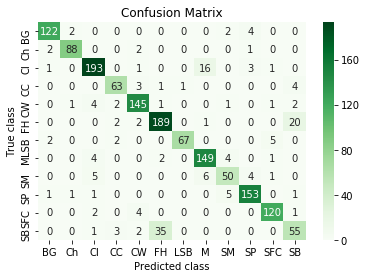

In [46]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True, fmt='g')
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

We can Conclude that the idea of using the stacked features from two different Networks was giving better results, we can also say that this is kind of method to ensemble. Using this, we were able to imporve both accuracy and reduce loss, though with less amount.
I have plotted graphs to show the loss and accuracy.

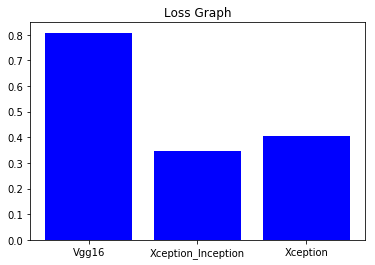

In [47]:

plt.bar(list(compare_loss.keys()), compare_loss.values(), color='b')
plt.xticks(range(0,3),list(compare_loss.keys()))
plt.title('Loss Graph')
plt.show()

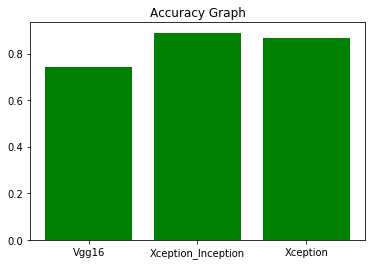

In [48]:
plt.bar(list(compare_accuracy.keys()), compare_accuracy.values(), color='g')
plt.xticks(range(0,3),list(compare_accuracy.keys()))
plt.title('Accuracy Graph')
plt.show()

### Create submission

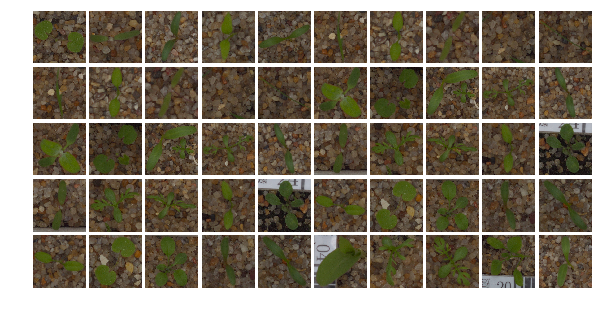

In [49]:
## show some test images 
import mpl_toolkits.axes_grid1

fig = plt.figure(1, figsize=(10, 10))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(5, 10), 
                                             axes_pad=0.05)
i = 0
for j in range(5):
    for filepath in test['filepath'].values[j*5:j*5+10]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        i += 1
        
plt.show();

In [50]:
INPUT_SIZE = 299
POOLING = 'avg'
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_id in tqdm(enumerate(test['file'])):
    img = read_img(img_id, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy().astype(np.float), axis=0)) # preprocessing data for Xception model
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

794it [00:06, 122.61it/s]


test Images shape: (794, 299, 299, 3) size: 212,953,182


In [43]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))

print('save Xception train bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_x_bf.npy'), train_x_bf)

794/794 [==============================] - ETA: 16:4 - ETA: 18:0 - ETA: 17:4 - ETA: 17:1 - ETA: 16:0 - ETA: 14:4 - ETA: 13:2 - ETA: 12:1 - ETA: 11:1 - ETA: 10:2 - ETA: 9:3 - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 30s - 944s 1s/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [52]:
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
test_i_bf = inception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('InceptionV3 test bottleneck features shape: {} size: {:,}'.format(test_i_bf.shape, test_i_bf.size))

print('save InceptionV3 train bottleneck features and labels for later ')
np.save(os.path.join(data_save_model,'train_i_bf.npy'), test_i_bf)

794/794 [==============================] - ETA: 8: - ETA: 8: - ETA: 7: - ETA: 7: - ETA: 7: - ETA: 6: - ETA: 6: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 38s - ETA: 17 - 527s 664ms/step
InceptionV3 test bottleneck features shape: (794, 2048) size: 1,626,112
save InceptionV3 train bottleneck features and labels for later 


In [56]:
# load bottleneck features and labels
test_x_bf = np.load(os.path.join(data_save_model,'test_x_bf.npy'))
# test_i_bf = np.load(os.path.join(data_save_model,'test_i_bf.npy'))

print('Test Xception bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
#print('InceptionV3 test bottleneck features shape: {} size: {:,}'.format(test_i_bf.shape, test_i_bf.size))

Test Xception bottleneck features shape: (794, 2048) size: 1,626,112


In [57]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=147)
logreg.fit(train_x_bf, Y_train_val)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
compare_loss['Xception']=log_loss(Y_val, valid_probs)
compare_accuracy['Xception']=accuracy_score(Y_vali_val, valid_preds)
print('Validation Xception LogLoss {}'.format(compare_loss['Xception']))
print('Validation Xception Accuracy {}'.format(compare_accuracy['Xception']))

Validation Xception LogLoss 0.4069318232911793
Validation Xception Accuracy 0.8673469387755102


In [58]:
test_preds = logreg.predict(test_x_bf)
print('y_test_pred_class_logreg.shape = ', test_preds.shape)

y_test_pred_class_logreg.shape =  (794,)


In [59]:
test['category_id'] = test_preds
test['species'] = [species[c] for c in test_preds]
test[['file', 'species']].to_csv('Test_lable_submission.csv', index=False)
labels = pd.read_csv(join(os.getcwd(), 'Test_lable_submission.csv'))

In [53]:
test.shape

(794, 4)

In [62]:
labels.head(2)

,file,species
0,0021e90e4.png,Shepherds Purse
1,003d61042.png,Common wheat


### Summary of Predicted test lable

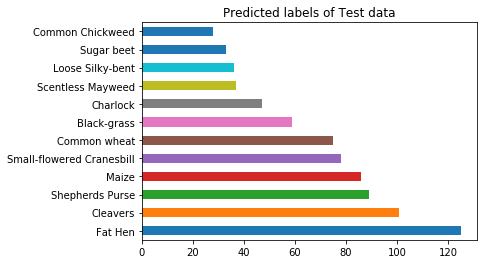

In [60]:
labels['species'].value_counts().plot(kind='barh', title='Predicted labels of Test data')